# Face Mask Recognition using CNN
## Final Project CS542
### Team members: Matheus de Almeida, Cyril Caparanga, Zachary Mecenas, Carolyn Wright

### Load Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import os
import random

import cv2

import tensorflow as tf

### Understanding Datasets

In [2]:
print(os.listdir("Data/FaceMaskDataset/Train/"))
print(os.listdir("Data/FaceMaskDataset/Validation/"))
print(os.listdir("Data/FaceMaskDataset/Test/"))

['WithMask', 'WithoutMask']
['WithMask', 'WithoutMask']
['WithMask', 'WithoutMask']


In [3]:
# Number of images in the training dataset

print('Images in the training dataset:\n')
print("Mask Images count - ", len(os.listdir("Data/FaceMaskDataset/Train/WithMask")))
print("Non Mask Images count - ", len(os.listdir("Data/FaceMaskDataset/Train/WithoutMask")))

Images in the training dataset:

Mask Images count -  5000
Non Mask Images count -  5000


In [4]:
# Number of images in the test dataset

print('Images in the test dataset:\n')
print("Mask Images count - ", len(os.listdir("Data/FaceMaskDataset/Test/WithMask")))
print("Non Mask Images count - ", len(os.listdir("Data/FaceMaskDataset/Test/WithoutMask")))

Images in the test dataset:

Mask Images count -  483
Non Mask Images count -  509


In [5]:
# Number of images in the Validation dataset

print('Images in the Validation dataset:\n')
print("Mask Images count - ", len(os.listdir("Data/FaceMaskDataset/Validation/WithMask")))
print("Non Mask Images count - ", len(os.listdir("Data/FaceMaskDataset/Validation/WithoutMask")))

Images in the Validation dataset:

Mask Images count -  400
Non Mask Images count -  400


In [2]:
train_dir = "Data/FaceMaskDataset/Train/"
val_dir = "Data/FaceMaskDataset/Validation/"
test_dir = "Data/FaceMaskDataset/Test/"

### Data Preprocessing - generate data from images

#### Investigate Resolution of Training Data

In [7]:
# Identify Image Resolutions Using WithMask Training Data

#https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05

# Import Packages
from PIL import Image
from pathlib import Path
import imagesize

# Get the Image Resolutions

imgs = [img.name for img in Path('Data/FaceMaskDataset/Train/WithMask').iterdir() if img.suffix == ".png"]

img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get('Data/FaceMaskDataset/Train/WithMask/'+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 5000


,FileName,Size,Width,Height,Aspect Ratio
0,Augmented_643_3267875.png,"(224, 224)",224,224,1.0
1,Augmented_368_6742462.png,"(224, 224)",224,224,1.0
2,Augmented_705_1630027.png,"(224, 224)",224,224,1.0
3,Augmented_85_1074191.png,"(224, 224)",224,224,1.0
4,Augmented_370_4709529.png,"(224, 224)",224,224,1.0


Text(0, 0.5, 'Height')

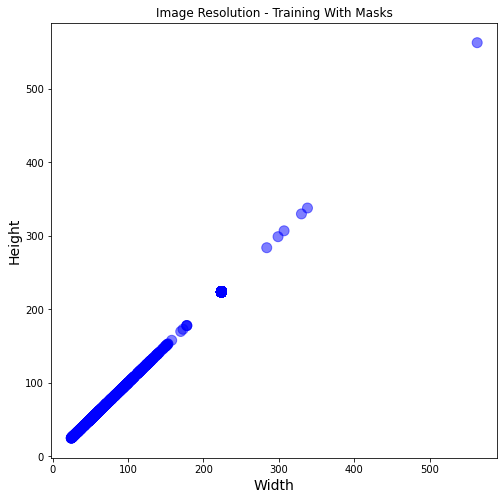

In [8]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution - Training With Masks")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

In [9]:
print("Avg width and height of Training Images with Masks:",np.mean(img_meta_df.Width), np.mean(img_meta_df.Height))

Avg width and height of Training Images with Masks: 201.6616 201.6616


In [10]:
# Identify Image Resolutions Using WithoutMask Training Data

# Import Packages
from PIL import Image
from pathlib import Path
import imagesize

# Get the Image Resolutions

imgs = [img.name for img in Path('Data/FaceMaskDataset/Train/WithoutMask').iterdir() if img.suffix == ".png"]

img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get('Data/FaceMaskDataset/Train/WithoutMask/'+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 5000


,FileName,Size,Width,Height,Aspect Ratio
0,4244.png,"(114, 114)",114,114,1.0
1,1828.png,"(114, 114)",114,114,1.0
2,228.png,"(115, 115)",115,115,1.0
3,4605.png,"(88, 88)",88,88,1.0
4,27.png,"(112, 112)",112,112,1.0


Text(0, 0.5, 'Height')

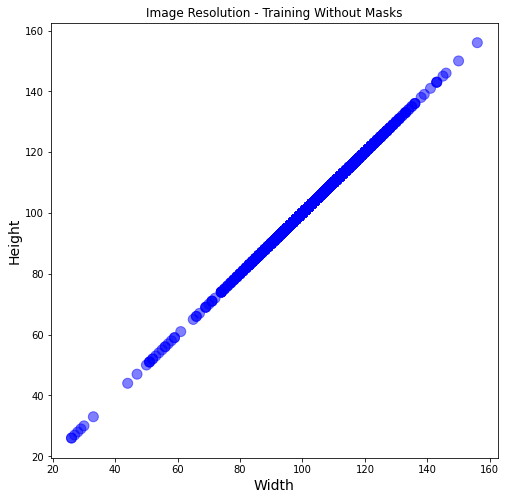

In [11]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution - Training Without Masks")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

In [12]:
print("Avg width and height of Training Images without Masks:",np.mean(img_meta_df.Width), np.mean(img_meta_df.Height))

Avg width and height of Training Images without Masks: 104.544 104.544


In [6]:
HEIGHT = 224
WIDTH = 224

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                         zoom_range=0.2,
                                         shear_range=0.2,
                                         rotation_range=0.2)

validation_datagen = ImageDataGenerator(rescale=1./255,
                                         zoom_range=0.2,
                                         shear_range=0.2,
                                        rotation_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(directory=train_dir,
                                          target_size=(HEIGHT,WIDTH),
                                          class_mode="categorical",
                                          batch_size=64
                                          )

val = validation_datagen.flow_from_directory(directory=val_dir,
                                            target_size=(HEIGHT,WIDTH),
                                            class_mode="categorical",
                                            batch_size=64)

test = test_datagen.flow_from_directory(directory=test_dir,
                                            target_size=(HEIGHT,WIDTH),
                                            class_mode="categorical",
                                            batch_size=64)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [14]:
#Remove final layer of VGG16 and replace with a dense layer with 2 classes using softmax activation

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D

vgg16_model = VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3), 
                classes=1000, 
                classifier_activation='softmax')
model = Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))

#using accuracy as a quality measurement due to having well balanced datasets(train, validation, and test)
model.compile(optimizer="adam",  loss=["categorical_crossentropy"], metrics=["accuracy"])


print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [15]:
#EarlyStopping: Implement Early stopping to prevent overfitting and potential memorization based on validation loss. 
#               Stop after 20 epochs of no improvement
#PlotLossesCallback: Add plotting of training and validation accuracy and loss as the model runs.

from keras.callbacks import EarlyStopping
from livelossplot.inputs.keras import PlotLossesCallback

plot_losses = PlotLossesCallback()

early= EarlyStopping(monitor='val_loss', patience=20)

callbacks_list = [early, plot_losses]



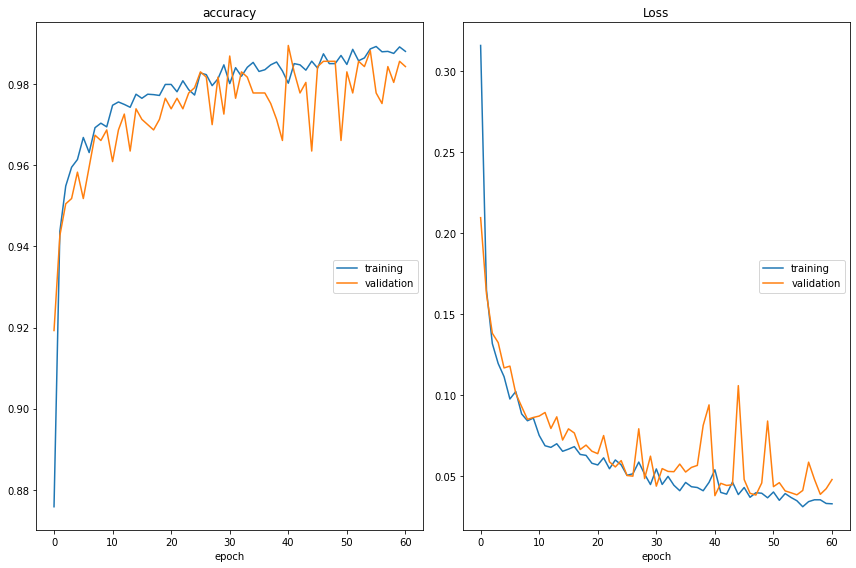

accuracy
	training         	 (min:    0.876, max:    0.989, cur:    0.988)
	validation       	 (min:    0.919, max:    0.990, cur:    0.984)
Loss
	training         	 (min:    0.031, max:    0.316, cur:    0.033)
	validation       	 (min:    0.038, max:    0.210, cur:    0.048)
156/156 [==============================] - 112s 718ms/step - loss: 0.0331 - accuracy: 0.9881 - val_loss: 0.0481 - val_accuracy: 0.9844


In [16]:
#Train model and test using entire training and validation data
hist= model.fit(train, 
                validation_data = val, 
                batch_size=64,
                steps_per_epoch=156, 
                epochs=1000, 
                validation_steps=12, 
                callbacks=[callbacks_list],
                verbose=1)


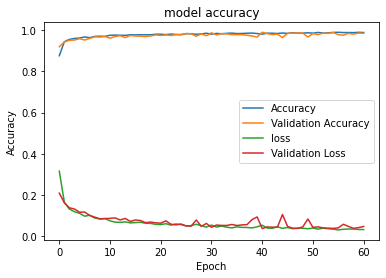

In [17]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
#plt.show()

#save off image of plot
plt.savefig('plot.png', dpi=300, bbox_inches='tight')

### Save off model

In [18]:
from tensorflow.keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


### Load in saved model

In [4]:
# load json and create model

from tensorflow.keras.models import model_from_json

json_file = open('model_final.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#load weights into new model
loaded_model.load_weights("model_final.h5")
print("Loaded model from disk")

Loaded model from disk


### Evaluate Model Accuracy on Test Set

In [7]:
loaded_model.compile(optimizer="adam",  loss=["categorical_crossentropy"], metrics=["accuracy"])
score = loaded_model.evaluate(test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[0], score[0]*100))

accuracy: 98.59%
loss: 3.68%


### Predict on test set images as well as ad hoc test set

In [8]:
testgen2 = test_datagen.flow_from_directory(directory=test_dir,
                                            target_size=(HEIGHT,WIDTH),
                                            batch_size=1,
                                            class_mode=None, 
                                            shuffle=False,
                                            seed=42)

predict_x2=loaded_model.predict(testgen2) 
classes_x2=np.argmax(predict_x2,axis=1)

class_indices2 = train.class_indices
class_indices2 = dict((v,k) for k,v in class_indices2.items())
true_classes2 = testgen2.classes

test_dir1 = "Data/Ad_hoc_testing"

testgen1 = test_datagen.flow_from_directory(directory=test_dir1,
                                            target_size=(HEIGHT,WIDTH),
                                            batch_size=1,
                                            class_mode=None, 
                                            shuffle=False,
                                            seed=42)

predict_x1=loaded_model.predict(testgen1) 
classes_x1=np.argmax(predict_x1,axis=1)

class_indices1 = train.class_indices
class_indices1 = dict((v,k) for k,v in class_indices1.items())
true_classes1 = testgen1.classes


Found 992 images belonging to 2 classes.
Found 17 images belonging to 2 classes.


### Plot results

In [9]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions1(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))
        
def plot_predictions2(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))



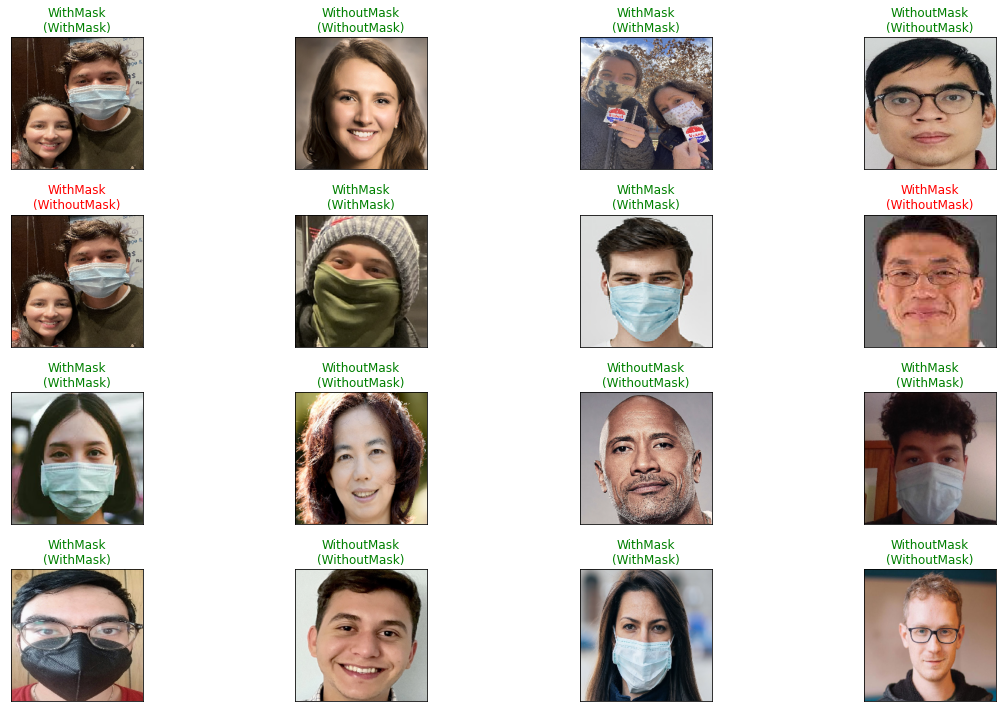

In [10]:
plot_predictions1(true_classes1, classes_x1, testgen1, class_indices1)


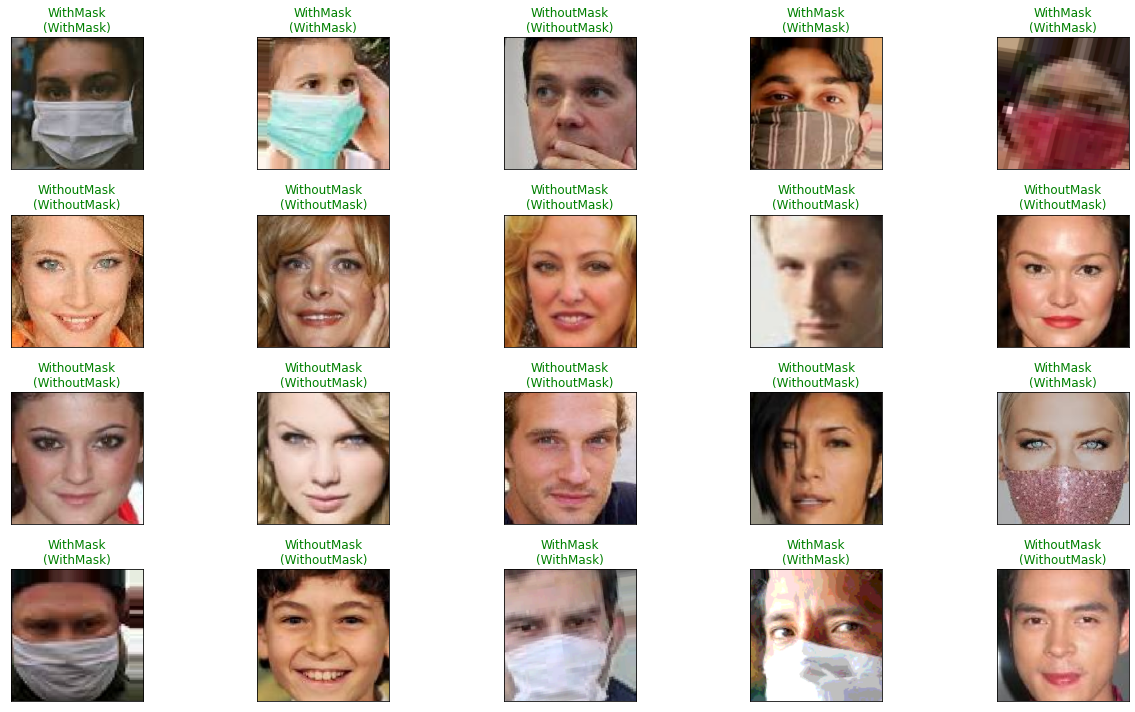

In [11]:
plot_predictions2(true_classes2, classes_x2, testgen2, class_indices2)

## Code References:

#### https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/#UsingImageDataGeneratorfortraining

#### https://www.kaggle.com/code/datauma/face-mask-detection

#### https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05